<h3 align="center"> Weed Detection with Fastai </h3>

<p <p style="text-align: center;"> This work is for the Weed Classification Project at Fintricity <br/ >
To run this notebook, you will need python3, pytorch and fastai libraries </p>

# <b/>I. Requirements:

Import libraries:

In [1]:
!pip3 uninstall -y fastai
!pip3 install fastai
# !pip3 install --upgrade seeme

     |████████████████████████████████| 354 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 37.7 MB/s eta 0:00:01
     |████████████████████████████████| 748.8 MB 4.2 kB/s  eta 0:00:01     |███████▉                        | 184.5 MB 57.0 MB/s eta 0:00:10/s eta 0:00:07
     |████████████████████████████████| 5.9 MB 57.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 49.6 MB/s eta 0:00:01
     |████████████████████████████████| 185 kB 63.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 56.3 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 49.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Reload the kernel if the next cell returns an error message.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import * # fastai library for vision application
import matplotlib.pyplot as plt # for ploting
from glob import glob # for path function
import cv2 # opencv2 library for handling images
from skimage.morphology import closing, disk, opening
import seaborn as sns
import random
import re

Define all directories that contain the dataset and directory for saving models

In [3]:
DATA_FOLDER = "/home/ec2-user/SageMaker/SugarBeetGrowth/data"
data_path = Path(DATA_FOLDER)
train_path = Path(os.path.join(DATA_FOLDER, "train"))
valid_path = Path(os.path.join(DATA_FOLDER, "valid"))
test_path = Path("/home/ec2-user/SageMaker/SugarBeetGrowth/test")
model_path = Path("/home/ec2-user/SageMaker/SugarBeetGrowth/models")

The structure of our <b>data</b> folder is:
    
    -->train
        --> Agrostemma-githago_Cotyledon
            --> image1.jpg
            --> image2.jpg
            -->...
        --> Agrostemma-githago_Foliage
        --> Agrostemma-githago_Intermediate
        --> Crepis-setosa_Cotyledon
        --> Crepis-setosa_Foliage
        --> Crepis-setosa_Intermediate
        --> Beta-vulgaris_Cotyledon
        --> Beta-vulgaris_Foliage
        --> Beta-vulgaris_Intermediate
    
    -->valid
        --> Agrostemma-githago_Cotyledon
            --> image1.jpg
            --> image2.jpg
            -->...
        --> Agrostemma-githago_Foliage
        --> Agrostemma-githago_Intermediate
        --> Crepis-setosa_Cotyledon
        --> Crepis-setosa_Foliage
        --> Crepis-setosa_Intermediate
        --> Beta-vulgaris_Cotyledon
        --> Beta-vulgaris_Foliage
        --> Beta-vulgaris_Intermediate
    


# <b/>II. Segmentation
## 1. Analysis

In [3]:
images_list = get_image_files(data_path)
total_images = len(images_list)
plantDataFrame = pd.DataFrame(index=np.arange(0, total_images), columns=["image_name", "classes", "width", "height", "is_valid"])
k = 0
for image_path in images_list:
    image = cv2.imread(str(image_path))
    plantDataFrame.loc[k, "image_name"] = image_path.name
    plantDataFrame.loc[k, "classes"] = image_path.parent.name
    plantDataFrame.loc[k, "width"] = image.shape[1]
    plantDataFrame.loc[k, "height"] = image.shape[0]
    plantDataFrame.loc[k, "is_valid"] = (image_path.parent.parent.name=='valid')
    k+=1

plantDataFrame.width = plantDataFrame.width.astype(np.int)
plantDataFrame.height = plantDataFrame.height.astype(np.int)

In [4]:
plantDataFrame

image_name  \
0                Beta-vulgaris_Foliage_Substrat1_11112019 (25).JPG   
1                 Beta-vulgaris_Foliage_Substrat2_08112019 (5).JPG   
2          Beta-vulgaris_Foliage_Substrat2_11112019_darker (7).JPG   
3                 Beta-vulgaris_Foliage_Substrat3_25102019 (8).JPG   
4                 Beta-vulgaris_Foliage_Substrat1_08112019 (3).JPG   
..                                                             ...   
247        Crepis-setosa_Intermediate_Substrat1_07022020 (171).JPG   
248  Crepis-setosa_Intermediate_Substrat2_10022020_darker (17).JPG   
249         Crepis-setosa_Intermediate_Substrat2_05022020 (81).JPG   
250         Crepis-setosa_Intermediate_Substrat2_05022020 (61).JPG   
251        Crepis-setosa_Intermediate_Substrat3_05022020 (109).JPG   

                        classes  width  height is_valid  
0         Beta-vulgaris_Foliage   3456    2304    False  
1         Beta-vulgaris_Foliage   3456    2304    False  
2         Beta-vulgaris_Foliage   3456    2304    False  
3         Beta-vulgaris_Foliage   3456    2304    False  
4         Beta-vulgaris_Foliage   3456    2304    False  
..                          ...    ...     ...      ...  
247  Crepis-setosa_Intermediate   3456    2304     True  
248  Crepis-setosa_Intermediate   3456    2304     True  
249  Crepis-setosa_Intermediate   3456    2304     True  
250  Crepis-setosa_Intermediate   3456    2304     True  
251  Crepis-setosa_Intermediate   3456    2304     True  

[252 rows x 5 columns]

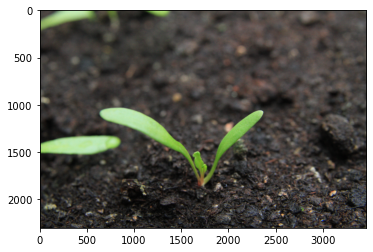

In [5]:
random.seed(13)
selected_image_path = random.choice(images_list)
pil_image = PILImage.create(selected_image_path)
np_image = np.array(pil_image)
image_hvs = cv2.cvtColor(np_image, cv2.COLOR_BGR2HSV)
image_lab = cv2.cvtColor(np_image, cv2.COLOR_BGR2LAB)
plt.imshow(np.asarray(pil_image))

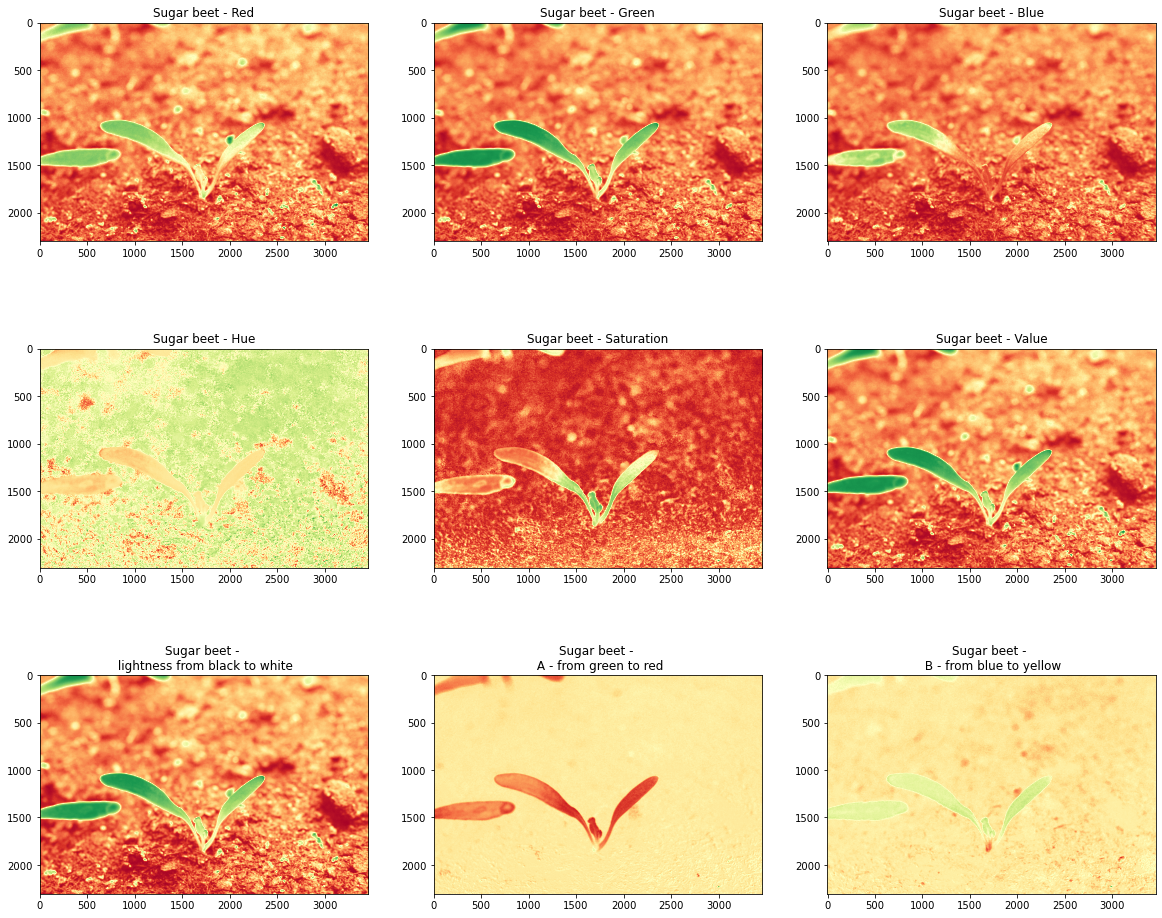

In [6]:
fig,ax = plt.subplots(3,3,figsize=(20,17))

titles = [["Red", "Green", "Blue"],
         ["Hue", "Saturation", "Value"],
         ["\n lightness from black to white", "\n A - from green to red", "\n B - from blue to yellow"]]

for n in range(3):
    ax[0,n].imshow(np_image[:,:,n], cmap="RdYlGn")
    ax[0,n].grid(False)
    ax[0,n].set_title("Sugar beet" + " - " + titles[0][n]);
    ax[1,n].imshow(image_hvs[:,:,n], cmap="RdYlGn")
    ax[1,n].set_title("Sugar beet" + " - " + titles[1][n]);
    ax[2,n].imshow(image_lab[:,:,n], cmap="RdYlGn")
    ax[2,n].set_title("Sugar beet" + " - " + titles[2][n]);
plt.savefig("Colorspace", dpi=500)

## 2. Define segmentation functions

In [7]:
my_threshold = 115
my_radius = 2

In [8]:
def get_mask(image, threshold, radius):
    mask = np.where(image < threshold, 1, 0)
    selem = disk(radius)
    mask = closing(mask, selem)
    return mask

In [9]:
def segment_plant(image_path, threshold=115, radius=2):
    pil_image = PILImage.create(image_path)
    np_image = np.array(pil_image)
    image_lab = cv2.cvtColor(np_image, cv2.COLOR_BGR2LAB)
    mask = get_mask(image_lab[:,:,1], threshold, radius)
    masked_image = np_image.copy()
    for n in range(3):
        masked_image[:,:,n] = np_image[:,:,n] * mask
    return masked_image

## 3. Functions testing

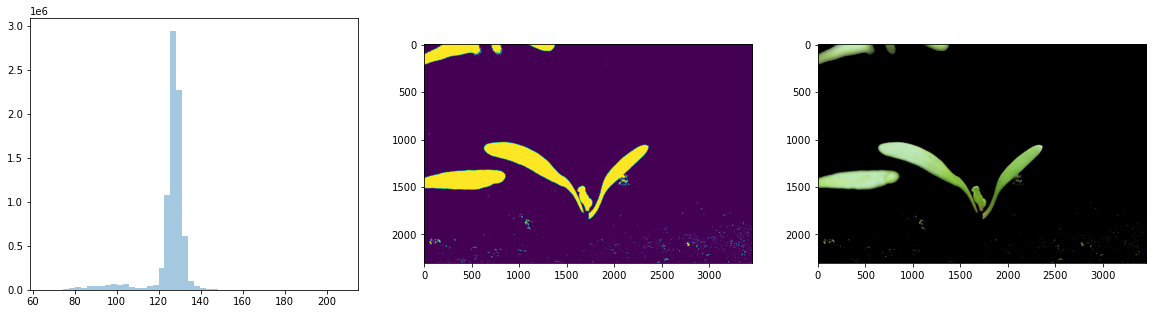

In [10]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(image_lab[:,:,1].flatten(), ax=ax[0], kde=False)
mask = get_mask(image_lab[:,:,1], my_threshold, my_radius)
ax[1].imshow(mask);
ax[2].imshow(segment_plant(selected_image_path, my_threshold, my_radius))
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

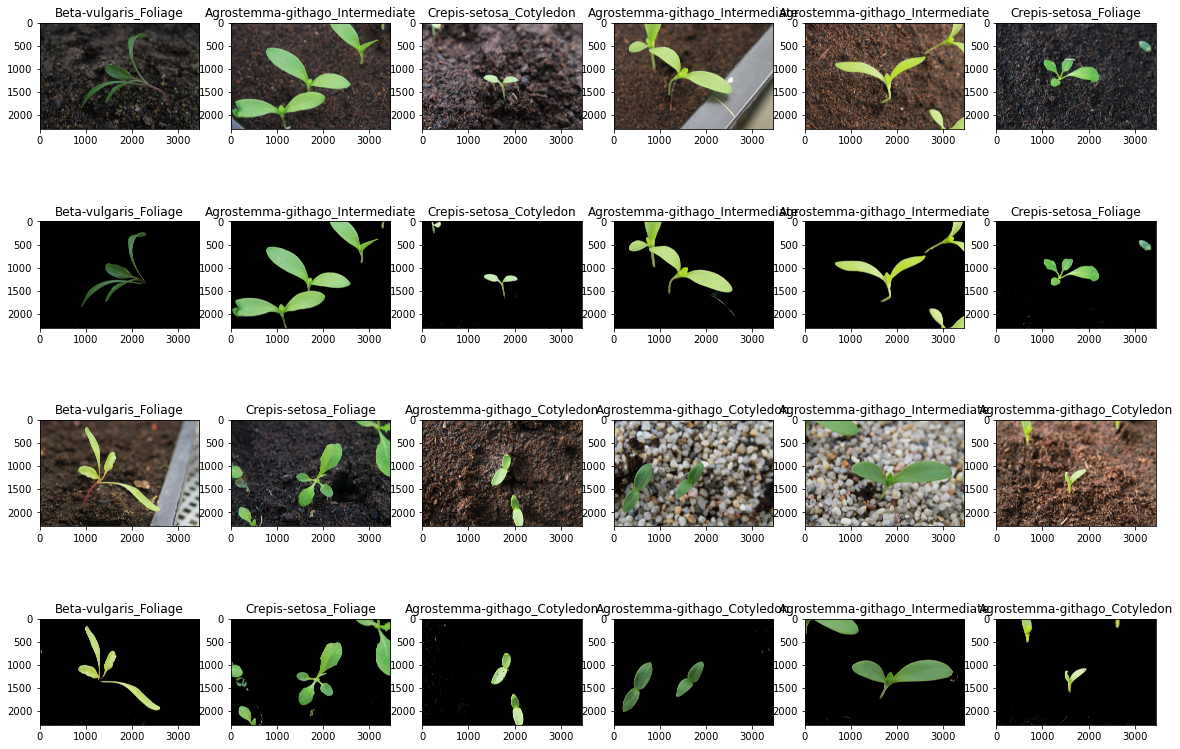

In [11]:
fig, ax = plt.subplots(4,6,figsize=(20,14))
random.shuffle(images_list)
for m in range(6):
    image = np.array(Image.open(str(images_list[m])))
    ax[0,m].imshow(image)
    ax[1,m].imshow(segment_plant(images_list[m], my_threshold, my_radius))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[0,m].set_title(images_list[m].parent.name)
    ax[1,m].set_title(images_list[m].parent.name)
    
    image = np.array(Image.open(str(images_list[m+6])))
    ax[2,m].imshow(image)
    ax[3,m].imshow(segment_plant(images_list[m+6], my_threshold, my_radius))
    ax[2,m].grid(False)
    ax[3,m].grid(False)
    ax[2,m].set_title(images_list[m+6].parent.name)
    ax[3,m].set_title(images_list[m+6].parent.name)

# <b/>III. Dataset Preparation

The original image size is 3456x2304 (pixels). We want to resize (cropping) images into a square size without removing too much important details. We resize into: 2304/3 = 768 pixel or 768x768 pixels <br/>
We may want to use progressive presizing strategy, therefore we define the function <i>get_dls(batch_size, image_size, path)</i>: 

## Data augmentation: 
Transformation: rotation, flipping, perspective warping, brightness changes and contrast changes. Because we do not do any zooming or stretching images, the perspective feature's size inside the images remains the same.

The default parameters are: 

**aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)**

The batch_tfms (batch transform is applied only to training data)

In [12]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=GrandparentSplitter(),
#                        get_x=segment_plant,
                       get_y=parent_label,
                       item_tfms=Resize(2304),
                       batch_tfms=[*aug_transforms(size=size, min_scale=1,mult=1),
                                   Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(data_path, bs=bs)

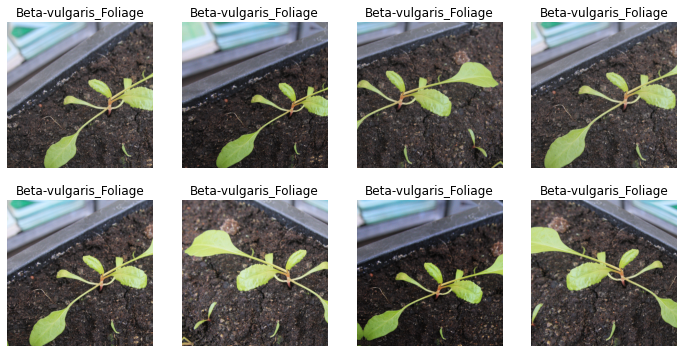

In [13]:
dls = get_dls(8,768)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

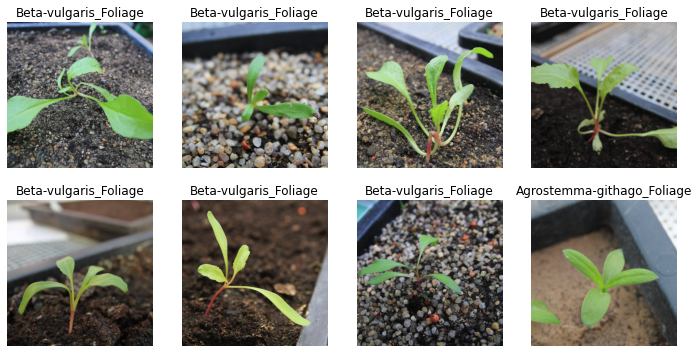

In [14]:
dls.valid.show_batch(max_n=8, nrows=2)

Print out the classes (augmented list): first output is the number of classes (9). The second output is a list of those classes

In [15]:
print(dls.vocab)

(#9) ['Agrostemma-githago_Cotyledon','Agrostemma-githago_Foliage','Agrostemma-githago_Intermediate','Beta-vulgaris_Cotyledon','Beta-vulgaris_Foliage','Beta-vulgaris_Intermediate','Crepis-setosa_Cotyledon','Crepis-setosa_Foliage','Crepis-setosa_Intermediate']


In [16]:
torch.cuda.empty_cache()

# <b/>IV. Training

Resnet18 is a good model to begin.

In [29]:
learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), cbs=MixUp, metrics = accuracy, model_dir = model_path)

Find the appropriate learning rate:

In [54]:
# learn.fit_one_cycle(120,3e-3)

In [57]:
learn.save('resnet18_stage1')

Path('/home/ec2-user/SageMaker/SugarBeetGrowth/models/resnet18_stage1.pth')

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=7.585775847473997e-07)

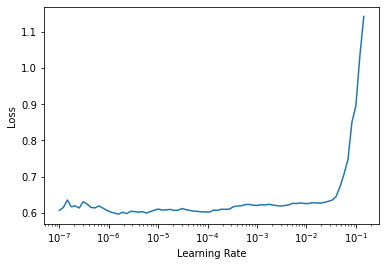

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(10,slice(3e-5,3e-3))

In [61]:
learn.save('resnet18_stage2')

Path('/home/ec2-user/SageMaker/SugarBeetGrowth/models/resnet18_stage2.pth')

#### Confusion matrix for resnet18 model

In [30]:
learn.load('resnet18_stage2')

In [32]:
learn.remove_cbs([ShowGraphCallback, MixUp])

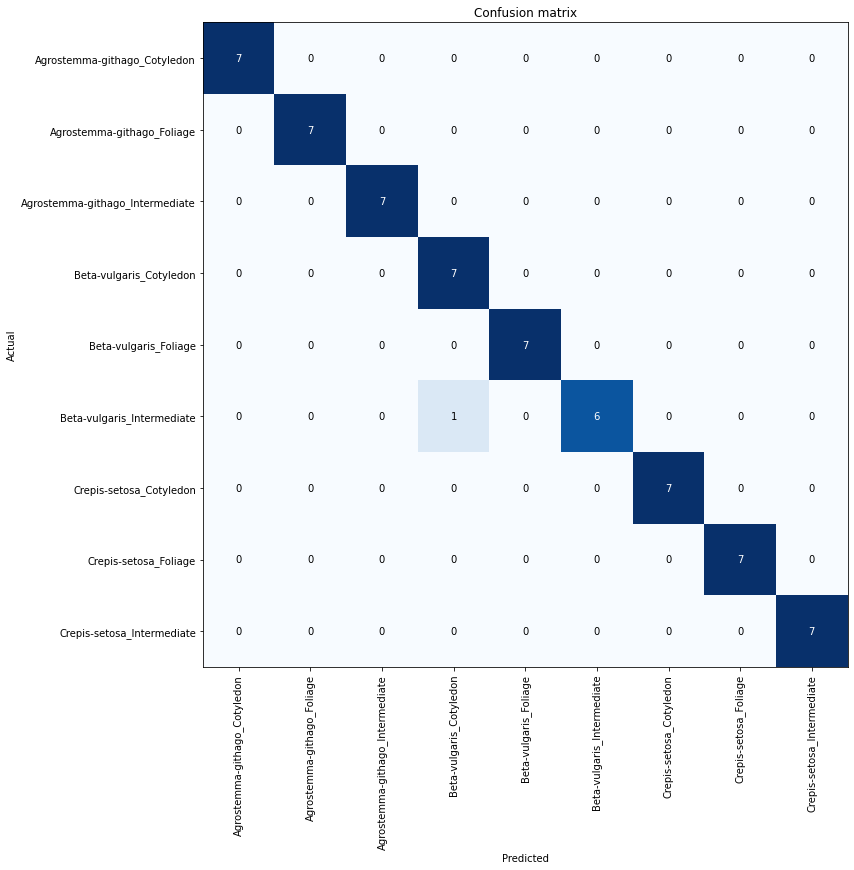

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12))

Ploting the images which resnet18 predicted wrong on validation data.

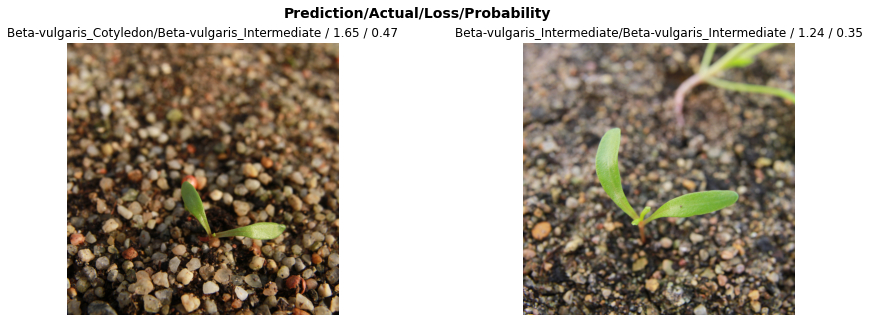

In [44]:
interp.plot_top_losses(2,figsize=(15,5))

Export the model, name it *model_name.pkl*

In [64]:
learn.export(model_path/'resnet18.pkl')

# Create Dataframe for test folder

In [45]:
imgs = get_image_files(test_path)
test_data = learn.dls.test_dl(imgs)
preds,y = learn.get_preds(dl=test_data)

In [46]:
predict = np.argmax(preds, axis = 1)

In [47]:
confidence = []
for i in range(0,18):
    confidence.append(float(preds[i][int(predict[i])]))
# maxd = max(confidence)
# mind = min(confidence)
# round(maxd)

In [48]:
# confi_array = np.asarray(confidence)
# confidenceA = (confi_array)/(round(maxd))

In [49]:
preds_classes = [dls.vocab[i] for i in predict]

In [50]:
def listdir_nohidden(path):
    return glob(os.path.join(path, '*'))
image_name_list = []
for item in listdir_nohidden(test_path):
    image_name_list.append(re.match(r'.+?(?=_Substrat)',os.path.basename(item)).group())
# image_name_list

In [51]:
# preds_classes

In [52]:
def compareList(l1, l2):
    return [i==j for i, j in zip(l1, l2)]
is_correct = compareList(image_name_list,preds_classes)
# is_correct

In [53]:
submission = pd.DataFrame({ 'image_name': image_name_list, 'prediction': preds_classes, 'confidence' : confidence, 'is_correct?': is_correct })
submission.to_csv('test_classification_results.csv', index=False)
submission

image_name                       prediction  \
0             Beta-vulgaris_Foliage            Beta-vulgaris_Foliage   
1   Agrostemma-githago_Intermediate  Agrostemma-githago_Intermediate   
2             Beta-vulgaris_Foliage            Beta-vulgaris_Foliage   
3             Crepis-setosa_Foliage            Crepis-setosa_Foliage   
4      Agrostemma-githago_Cotyledon     Agrostemma-githago_Cotyledon   
5        Beta-vulgaris_Intermediate       Beta-vulgaris_Intermediate   
6           Crepis-setosa_Cotyledon          Crepis-setosa_Cotyledon   
7        Agrostemma-githago_Foliage       Agrostemma-githago_Foliage   
8      Agrostemma-githago_Cotyledon            Crepis-setosa_Foliage   
9             Crepis-setosa_Foliage            Crepis-setosa_Foliage   
10          Beta-vulgaris_Cotyledon          Beta-vulgaris_Cotyledon   
11       Agrostemma-githago_Foliage       Agrostemma-githago_Foliage   
12            Beta-vulgaris_Foliage            Beta-vulgaris_Foliage   
13          Beta-vulgaris_Cotyledon          Beta-vulgaris_Cotyledon   
14       Beta-vulgaris_Intermediate       Beta-vulgaris_Intermediate   
15          Crepis-setosa_Cotyledon          Crepis-setosa_Cotyledon   
16  Agrostemma-githago_Intermediate  Agrostemma-githago_Intermediate   
17       Crepis-setosa_Intermediate       Crepis-setosa_Intermediate   

    confidence  is_correct?  
0     0.910910         True  
1     0.869914         True  
2     0.906840         True  
3     0.761936         True  
4     0.915741         True  
5     0.761590         True  
6     0.756794         True  
7     0.943277         True  
8     0.292605        False  
9     0.562800         True  
10    0.861984         True  
11    0.958536         True  
12    0.917896         True  
13    0.752026         True  
14    0.808136         True  
15    0.841458         True  
16    0.874756         True  
17    0.911816         True

## Export model and upload to S3
Now that we have trained our model we need to export it, create a tarball of the artefacts and upload to S3.

First we need to get the S3 bucket and prefix where the model will be uploaded to.

In [5]:
export_path = Path('/home/ec2-user/SageMaker/SugarBeetGrowth/models')

Compress the *.pkl* file

In [57]:
import tarfile
with tarfile.open(export_path/'model.tar.gz', 'w:gz') as f:
    f.add(export_path/'resnet18.pkl', arcname='model.pkl')

Define sagemaker required parameters in order to upload model artefact to S3 

In [6]:
import sagemaker
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
prefix = 'resnet18-sagemaker-sugarbeet'

In [7]:
model_location = sess.upload_data(str(export_path/'model.tar.gz'), key_prefix=prefix)
model_location

's3://sagemaker-eu-west-1-993042807048/resnet18-sagemaker-sugarbeet/model.tar.gz'

Create the model for inference. Serve.py script:

In [ ]:
!pygmentize scripts/serve.py

In [8]:
from sagemaker.pytorch import PyTorchModel

In [9]:
model = PyTorchModel(model_data=model_location,
                     role=role,
                     framework_version='1.5.0',
                     entry_point='serve.py', 
                     source_dir='scripts')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Deploy the endpoint to Sagemaker, it will take some minutes to finish

In [ ]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------

Download some images from somewhere (need a URL) and store it inside a folder named */tmp*

In [ ]:
# ! [ -d tmp ] || mkdir tmp
# ! wget -q -O tmp/Agrostemma-githago_Cotyledon1.jpg https://www.dropbox.com/s/wrl6ehdivktfz3p/Agrostemma-githago_Cotyledon_Substrat3_12022020%20%28229%29.JPG?raw=1
# ! wget -q -O tmp/Agrostemma-githago_Cotyledon2.jpg https://www.dropbox.com/s/1t3enu6vjbxr1zr/Agrostemma-githago_Cotyledon_Substrat3_12022020%20%28258%29.JPG?raw=1
# ! wget -q -O tmp/Agrostemma-githago_Foliage1.jpg https://www.dropbox.com/s/gx7aq2eyrt0l5s5/Agrostemma-githago_Foliage_Substrat3_28022020%20%2873%29.JPG?raw=1
# ! wget -q -O tmp/Agrostemma-githago_Foliage2.jpg https://www.dropbox.com/s/8rd35rn1aj5mxe1/Agrostemma-githago_Foliage_Substrat3_28022020%20%28216%29.JPG?raw=1   
# ! wget -q -O tmp/Agrostemma-githago_Intermediate1.jpg https://www.dropbox.com/s/h8256ag2hwssdui/Agrostemma-githago_Intermediate_Substrat3_19022020%20%2829%29.JPG?raw=1
# ! wget -q -O tmp/Agrostemma-githago_Intermediate2.jpg https://www.dropbox.com/s/zh5ps93g1xdl5po/Agrostemma-githago_Intermediate_Substrat3_19022020%20%2863%29.JPG?raw=1
# ! wget -q -O tmp/Beta-vulgaris_Cotyledon1.jpg https://www.dropbox.com/s/1ilv2qazazsk9q3/Beta-vulgaris_Cotyledon_Substrat1_07102019%20%289%29.JPG?raw=1
# ! wget -q -O tmp/Beta-vulgaris_Cotyledon2.jpg https://www.dropbox.com/s/2iwsuccg2e6qdum/Beta-vulgaris_Cotyledon_Substrat1_07102019_darker%20%281%29.JPG?raw=1
# ! wget -q -O tmp/Beta-vulgaris_Foliage1.jpg https://www.dropbox.com/s/eoop3rnvukiaz9u/Beta-vulgaris_Foliage_Substrat1_04112019%20%2810%29.JPG?raw=1
# ! wget -q -O tmp/Beta-vulgaris_Foliage2.jpg https://www.dropbox.com/s/kvwzmsc6nr9xsv5/Beta-vulgaris_Foliage_Substrat1_04112019%20%2817%29.JPG?raw=1
# ! wget -q -O tmp/Beta-vulgaris_Intermediate1.jpg https://www.dropbox.com/s/z5w9odscqkafxp8/Beta-vulgaris_Intermediate_Substrat1_01092019%20%2825%29.JPG?raw=1
# ! wget -q -O tmp/Beta-vulgaris_Intermediate2.jpg https://www.dropbox.com/s/slx8ss6a0ogbdix/Beta-vulgaris_Intermediate_Substrat1_01092019%20%2851%29.JPG?raw=1
# ! wget -q -O tmp/Crepis-setosa_Cotyledon1.jpg https://www.dropbox.com/s/6u7wldxfqwoiby0/Crepis%20-setosa_Cotyledon_Substrat3_29012020%20%28107%29.JPG?raw=1
# ! wget -q -O tmp/Crepis-setosa_Cotyledon2.jpg https://www.dropbox.com/s/fpmxgbkt5wjqmrm/Crepis%20-setosa_Cotyledon_Substrat3_29012020%20%28116%29.JPG?raw=1
# ! wget -q -O tmp/Crepis-setosa_Foliage1.jpg https://www.dropbox.com/s/c3gmm8b08v821qu/Crepis-setosa_Foliage_Substrat1_17022020%20%281%29.JPG?raw=1
# ! wget -q -O tmp/Crepis-setosa_Foliage2.jpg https://www.dropbox.com/s/xqtb4g26wj3y4ob/Crepis-setosa_Foliage_Substrat1_17022020%20%28121%29.JPG?raw=1
# ! wget -q -O tmp/Crepis-setosa_Intermediate1.jpg https://www.dropbox.com/s/jvtt2mzegn63jhb/Crepis-setosa_Intermediate_Substrat1_05022020%20%281%29.JPG?raw=1
# ! wget -q -O tmp/Crepis-setosa_Intermediate2.jpg https://www.dropbox.com/s/hh9kjxj55c15uk9/Crepis-setosa_Intermediate_Substrat1_05022020%20%28114%29.JPG?raw=1

In [ ]:
# link1 = 'https://www.dropbox.com/s/wrl6ehdivktfz3p/Agrostemma-githago_Cotyledon_Substrat3_12022020%20%28229%29.JPG?raw=1'
# link2 = 'https://www.dropbox.com/s/1t3enu6vjbxr1zr/Agrostemma-githago_Cotyledon_Substrat3_12022020%20%28258%29.JPG?raw=1'
# link3 = 'https://www.dropbox.com/s/gx7aq2eyrt0l5s5/Agrostemma-githago_Foliage_Substrat3_28022020%20%2873%29.JPG?raw=1'
# link4 = 'https://www.dropbox.com/s/8rd35rn1aj5mxe1/Agrostemma-githago_Foliage_Substrat3_28022020%20%28216%29.JPG?raw=1'
# link5 = 'https://www.dropbox.com/s/h8256ag2hwssdui/Agrostemma-githago_Intermediate_Substrat3_19022020%20%2829%29.JPG?raw=1'
# link6 = 'https://www.dropbox.com/s/zh5ps93g1xdl5po/Agrostemma-githago_Intermediate_Substrat3_19022020%20%2863%29.JPG?raw=1'
# link7 = 'https://www.dropbox.com/s/1ilv2qazazsk9q3/Beta-vulgaris_Cotyledon_Substrat1_07102019%20%289%29.JPG?raw=1'
# link8 = 'https://www.dropbox.com/s/2iwsuccg2e6qdum/Beta-vulgaris_Cotyledon_Substrat1_07102019_darker%20%281%29.JPG?raw=1'
# link9 = 'https://www.dropbox.com/s/eoop3rnvukiaz9u/Beta-vulgaris_Foliage_Substrat1_04112019%20%2810%29.JPG?raw=1'
# link10 = 'https://www.dropbox.com/s/kvwzmsc6nr9xsv5/Beta-vulgaris_Foliage_Substrat1_04112019%20%2817%29.JPG?raw=1'
# link11 = 'https://www.dropbox.com/s/z5w9odscqkafxp8/Beta-vulgaris_Intermediate_Substrat1_01092019%20%2825%29.JPG?raw=1'
# link12 = 'https://www.dropbox.com/s/slx8ss6a0ogbdix/Beta-vulgaris_Intermediate_Substrat1_01092019%20%2851%29.JPG?raw=1'
# link13 = 'https://www.dropbox.com/s/6u7wldxfqwoiby0/Crepis%20-setosa_Cotyledon_Substrat3_29012020%20%28107%29.JPG?raw=1'
# link14 = 'https://www.dropbox.com/s/fpmxgbkt5wjqmrm/Crepis%20-setosa_Cotyledon_Substrat3_29012020%20%28116%29.JPG?raw=1'
# link15 = 'https://www.dropbox.com/s/c3gmm8b08v821qu/Crepis-setosa_Foliage_Substrat1_17022020%20%281%29.JPG?raw=1'
# link16 = 'https://www.dropbox.com/s/xqtb4g26wj3y4ob/Crepis-setosa_Foliage_Substrat1_17022020%20%28121%29.JPG?raw=1'
# link17 = 'https://www.dropbox.com/s/jvtt2mzegn63jhb/Crepis-setosa_Intermediate_Substrat1_05022020%20%281%29.JPG?raw=1'
# link18 = 'https://www.dropbox.com/s/hh9kjxj55c15uk9/Crepis-setosa_Intermediate_Substrat1_05022020%20%28114%29.JPG?raw=1'

## Test 1

Test the predictor. We throw in some data which the model has never seen before, wait to see it react...

In [34]:
img = PILImage.create('tmp/Agrostemma-githago_Cotyledon1.jpg')

In [46]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

# response = predictor.predict(img)
response = predictor.predict( { "url": 'https://www.dropbox.com/s/1t3enu6vjbxr1zr/Agrostemma-githago_Cotyledon_Substrat3_12022020%20%28258%29.JPG?raw=1' })
print(response)

{'class': 'Agrostemma-githago_Cotyledon', 'confidence': '91.57412052154541 %'}


Good result!

# Cleaning up

To save cost, we need to delete the endpoint after using it.

In [50]:
predictor.delete_endpoint()

In [51]:
predictor.delete_model()

# SeeMe.ai

In [6]:
from seeme import Client

client = Client()

In [8]:
my_password =  # example: "supersecurepassword"
my_username = # example: "janvdp"
my_email =  "nguyencaokha131995@gmail.com"# example: "jan.vandepoel@seeme.ai"
my_firstname =  "Kay"# example: "Jan"
my_name =  "Nguyen"# example: "Van de Poel"

client.register(
  username=my_username,
  email=my_email,
  password=my_password,
  firstname=my_firstname,
  name=my_name
)

{'id': 'e19d8e35-3396-4237-889e-1181f37a4deb',
 'created_at': '2020-09-12T21:41:34.281036385Z',
 'update_at': '2020-09-12T21:41:34.281036385Z',
 'deleted_at': None,
 'username': 'KayNguyen',
 'email': 'nguyencaokha131995@gmail.com',
 'name': 'Kay Nguyen',
 'firstname': 'Kay',
 'hashed_password': '$2a$14$DxdQaQAL2v56RjY4DeMY0uEMtWVXGGhU6pJEUroF8Hm72Fu8UJBp2',
 'last_login': '0001-01-01T00:00:00Z',
 'last_api_access': '0001-01-01T00:00:00Z',
 'apikey': '72765a38-c1c5-4547-bc29-10b4de6ae033',
 'Models': None,
 'TrainingRequests': None}

In [9]:
client.login(my_username, my_password)

{'id': 'e19d8e35-3396-4237-889e-1181f37a4deb',
 'username': 'KayNguyen',
 'name': 'Kay Nguyen',
 'email': 'nguyencaokha131995@gmail.com',
 'firstname': 'Kay',
 'apikey': '72765a38-c1c5-4547-bc29-10b4de6ae033'}

In [17]:
learn.load('resnet18_stage2')

In [21]:

# Put your model in eval model
learn.model.eval();

# Export your model (by default your model will be exported to `export.pkl`)
learn.export(model_path/'resnet18.pkl')

## Alternatively, if you want to give the exported file a name

# my_custom_filename = "a_filename_to_remember.pkl"

# learn.export(my_custom_filename)

In [22]:
import torch
import fastai

# Get the application_id for your framework (version).
application_id = client.get_application_id(
  base_framework="pytorch",
  framework="fastai",
  base_framework_version=str(torch.__version__), # or pass the version like a string: "1.6.0"
  framework_version=str(fastai.__version__), # or pass the version like a string: "2.0.10"
  application="image_classification"
)

In [23]:
model_name = "SugarBeetClassifier"
description = "9 classes classifier"
classes = "3 types of sugarbeet with 3 growth stages"

my_model = client.create_full_model({
    "name": model_name,
    "description": description,
    "classes": classes,
    "application_id": application_id
})

In [24]:
from pprint import pprint
pprint(client.applications)

[{'application': 'image_classification',
  'base_framework': 'pytorch',
  'base_framework_version': '1.5.0',
  'can_convert_to_coreml': False,
  'can_convert_to_onnx': False,
  'can_convert_to_tensorflow': False,
  'can_convert_to_tflite': False,
  'created_at': '2020-06-16T08:23:30.089658Z',
  'deleted_at': None,
  'framework': 'fastai',
  'framework_version': '1.0.61',
  'id': '1550e20c-6b84-45df-bf01-8ae282ba9f6d',
  'inference_host': 'image-pt-1-5-0-fa-1-0-61',
  'update_at': '2020-06-16T08:23:30.089658Z'},
 {'application': 'image_classification',
  'base_framework': 'pytorch',
  'base_framework_version': '1.4.0',
  'can_convert_to_coreml': False,
  'can_convert_to_onnx': False,
  'can_convert_to_tensorflow': False,
  'can_convert_to_tflite': False,
  'created_at': '2020-06-16T08:23:30.227328Z',
  'deleted_at': None,
  'framework': 'fastai',
  'framework_version': '1.0.60',
  'id': '1e032f9a-9b39-4f1f-8198-f78ad770a990',
  'inference_host': 'image-pt-1-4-0-fa-1-0-60',
  'update_at'

In [34]:
# client.upload_model(my_model["id"], "folder/to/model")

# Or, if you exported the model with a custom filename
client.upload_model(
  my_model["id"],
  folder=str(model_path),
  filename="resnet18.pkl"
)

{'id': '22784f51-53cc-4816-8766-00f370c6ca5e',
 'created_at': '2020-09-12T21:47:46.847479Z',
 'update_at': '2020-09-12T21:53:36.758518549Z',
 'deleted_at': None,
 'name': 'SugarBeetClassifier',
 'description': '9 classes classifier',
 'classes': '3 types of sugarbeet with 3 growth stages',
 'count': 0,
 'precision': 0,
 'recall': 0,
 'accuracy': 0,
 'user_id': 'e19d8e35-3396-4237-889e-1181f37a4deb',
 'can_inference': True,
 'kind': '',
 'has_logo': False,
 'logo': '',
 'public': False,
 'config': '',
 'base_framework': '',
 'base_version': '',
 'framework': '',
 'application_id': '1c761e4f-5dba-43df-bb6a-b9d6ccc7ee3c',
 'version': '',
 'has_ml_model': True,
 'has_onnx_model': True,
 'dataset_version_id': ''}

In [33]:
str(model_path)

'/home/ec2-user/SageMaker/SugarBeetGrowth/models'